In [ ]:
import pandas  as pd

### 簡易使用API
https://github.com/tdxmotc/SampleCode/blob/master/Python3/auth_TDX.py

先透過官方提供的API使用說明
把拿到的id跟Key依照額外檔案或是寫在程式碼中，方便後續使用

成果如 https://github.com/1daniel3333/TW_railway/blob/main/auth_TDX.py

In [ ]:
#匯入程式碼，並且只需要給定api 名稱就可以呼叫
from auth_TDX import get_api_return_df

api_use = '/v3/Rail/TRA/Station' #這邊使用拿到車站名稱
train_basic_info = get_api_return_df(api_use)
train_basic_info.head()

### 拿到車站資料對應的車站號碼
可以看到拿到的資訊第一層主要是基本時間等資訊，細部資訊放在"Stations"裡面，所以我們需要再針對這個資料做整理

In [ ]:
def get_train_basic_station()->pd.DataFrame:
    #先把資料做成一個function，方便後續呼叫
    #get basic information
    api_use = '/v3/Rail/TRA/Station'
    train_basic_info = get_api_return_df(api_use)
    return train_basic_info

### 觀察資料
運行下面程式，可以發現是一個JSON format，這邊我們實際需要的是車站名稱(StationName)的中文(Zh_tw) 以及對應的車站ID(StationID)
目標是做出一個對應表，讓我們可以由中文找到車站ID

In [ ]:
train_basic_info['Stations'][0] #check what's the data inside Ststions looks like

In [ ]:
def gen_train_hash_from_df(data)->dict:
    """
    Args:
        data (_type_): API回傳的車站資料

    Raises:
        ValueError: 如果遇到異常，就反應錯誤

    Returns:
        dict: 做好的hash map
    """
    data = {}
    try:
        for i, row in train_basic_info.iterrows():
            station_name = row['Stations']['StationName']['Zh_tw']
            station_id = row['Stations']['StationID']
            data[station_name] = station_id
    except:
        raise ValueError('Get unexpected data type.')
    return data

In [ ]:
train_basic_info = get_train_basic_station()
train_hash = gen_train_hash_from_df(train_basic_info)
for name,id in list(train_hash.items())[0:10]:
    print(f"車站 {name} 的ID是 {id}")

### 拿到給定啟始結束車站以及日期的發車資訊
由上面我們已經拿到對應表，現在要去做一個給定起始跟結束車站還有日期，拿到發車資訊的程式
1.打字時"臺台"都是我們常用的方法，但字典只接受"臺"，我們可以簡單透過replace來修正 (get_train_num_from_train_name)
2.在使用下表API時，規定的日期格式為yyyy-MM-dd，因此寫一個可以取得規定方法的日期格式(get_today_format)

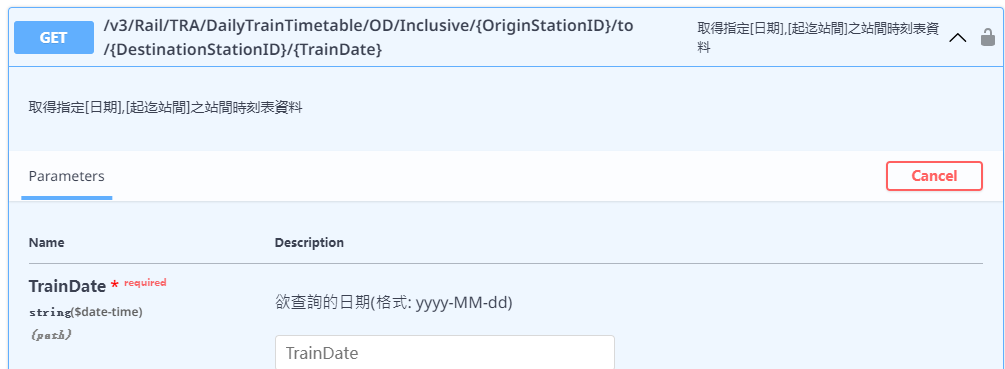

3.打包以上的程式，基本流程為使用者給定"起始"，"結束"車站，以及日期(optional)，如果沒給日期就會預設今日，最後會回傳呼叫API後的df (get_train_list_from_ini_station_fin_station_date)

In [ ]:
def get_train_num_from_train_name(train_name:str, hash:dict=train_hash)->str:
    train_name_new = train_name.replace('台','臺')
    return hash[train_name_new]

def get_today_format()->str:
    import datetime
    current_date = datetime.date.today()
    return current_date.strftime("%Y-%m-%d")

def get_train_list_from_ini_station_fin_station_date(ini_station:str, fin_station:str, train_date:str=get_today_format())->pd.DataFrame:
    """_summary_

    Args:
        ini_station (str): input as a two word station
        fin_station (str): input as a two word station
        train_date (str, optional): _description_. Defaults to get_today_format(), format yyyy-MM-dd

    Returns:
        pd.DateFrame: Data from API
    """
    OriginStationID = get_train_num_from_train_name(ini_station)
    DestinationStationID = get_train_num_from_train_name(fin_station)
    test = f'/v3/Rail/TRA/DailyTrainTimetable/OD/Inclusive/{OriginStationID}/to/{DestinationStationID}/{train_date}'
    train_time_table = get_api_return_df(test)
    return train_time_table

In [ ]:
get_train_data = get_train_list_from_ini_station_fin_station_date('后里','台中')

### 觀察資料，整理起訖車站的資訊
拿到get_train_data後，去拆解資料

In [ ]:
temp = get_train_data['TrainTimetables'][0] #check what's inside
temp

### 以下是需要的資訊的位置

temp['TrainInfo']['TrainNo'] # this is train number 車次號碼

temp['TrainInfo']['StartingStationID'] #this is the answer of whether train start is station start 該車次的發車車站

temp['StopTimes'][0]['StationID'] #here is the stop station ID 該車次會停的車站ID

temp['StopTimes'][0]['ArrivalTime'] #here is the stop station time 該車次在某車站的停車時間

### 後續就是把觀察到的資訊去做包裝
1.每個車站的停車資訊會放在"StopTimes"，因此給定要查的車站去回傳一個車站:抵達時間 的map (get_arrivetime_by_strain_info)

2.每一個班次中的資料拆開來處理，目標為取得班次中，指定的起迄車站發車時間，班次號碼還有起始車站是否為發車車站(get_train_sum_info_from_train_dict)

3.for loop去把一天中的車次都做同樣分析並回傳(gen_train_api_info_to_df)

In [ ]:
def get_arrivetime_by_strain_info(train_info:list, train_list:list)->dict:
    """_summary_

    Args:
        train_info (list): this should be train API return dataframe ['TrainTimetables'][i]['StopTimes'], each element in list is a dict
        train_list (list): list of train id to get time

    Returns:
        dict: train start time by input train list sequence, key is train id and value is time
    """
    res = {}
    for i in range(len(train_info)):
        station_id = train_info[i]['StationID']
        if station_id == train_list[0]:
            res['Start_Station'] = train_info[i]['ArrivalTime']
        elif station_id == train_list[1]:
            res['Arrive_Station'] = train_info[i]['ArrivalTime']
    return res

def get_train_sum_info_from_train_dict(train_info:dict, ini_station:str, fin_station:str):
    """_summary_

    Args:
        train_info (dict): data from API
        ini_station (str): in chinese
        fin_station (str): in chinese
    """
    train_num = train_info['TrainInfo']['TrainNo']
    train_start_loc = train_info['TrainInfo']['StartingStationID']
    OriginStationID = get_train_num_from_train_name(ini_station)
    DestinationStationID = get_train_num_from_train_name(fin_station)
    time_hash = get_arrivetime_by_strain_info(train_info['StopTimes'], [OriginStationID, DestinationStationID])
    time_hash['Train_ID'] = train_num
    time_hash['Is_init_station'] = (train_start_loc==OriginStationID)
    return time_hash

def gen_train_api_info_to_df(data:pd.DataFrame, ini_station:str, fin_station:str)->pd.DataFrame:
    summary_train_status = []
    for i in data['TrainTimetables']:
        summary_train_status.append(get_train_sum_info_from_train_dict(i, ini_station,fin_station))
    return pd.DataFrame(summary_train_status)

In [ ]:
check_data = gen_train_api_info_to_df(get_train_data, '后里','台中')
check_data.tail()

### Final form 
最終還是需要把function都包裝好方便未來使用

把上面的function都放進TDX_application

In [ ]:
import TDX_application 

hash = TDX_application.get_hash()

get_train_data = TDX_application.get_train_list_from_ini_station_fin_station_date('台中','台南',hash)

time_table = TDX_application.gen_train_api_info_to_df(get_train_data, '台中','台南',hash)

In [ ]:
time_table[time_table['Is_init_station']==True] #檢查搭乘站又是起始站的班次

### 結語
如此一來，就完成API使用，台鐵APP有許多功能也都是這些API呼叫的結果，有這樣的平台就可以讓常搭車卻覺得臺鐵APP仍有不足功能時，可以客製化自己的需求